# One-shot learning implementation for fish recognition
Using the [fish4knowledge Fish Recognition Ground-Truth dataset](https://github.com/brendenlake/omniglot/tree/master/python)

### TODO
- entrainer sans negatif ?
- normalization des entrées (pour same ?)
- data augmentation ?
- comparer avec et sans
  - batch norm
  - batch norm au début
  - dropout
  - regul

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup phase
We install packages, make all imports, configure modules and download dataset

In [0]:
%%bash
pip install -q pyyaml
pip install tensorflow==2.0.0-beta1
pip install -q tensorflow-gpu==2.0.0-beta1

In [0]:
%%bash
mkdir datas
ls "/content/drive/My Drive/ml/datas"
unzip -q "/content/drive/My Drive/ml/datas/fishdb.zip" -d datas

fishdb.zip
fishes_all_augmented.zip
fishes_all.zip
fishes_one_shot.zip
fishes_species.zip
taiwan_db.zip


mkdir: cannot create directory ‘datas’: File exists
replace datas/fishdb/Honeycomb Cowfish/9.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [0]:
%load_ext tensorboard

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import pandas as pd
import numpy as np
import skimage
from skimage import transform as sktrans

from tensorflow.keras import layers
from tensorflow.keras import datasets, layers, models
from tensorboard import notebook
from keras import backend as K
from IPython import display

import os, datetime, time, math, pathlib, itertools, random

keras = tf.keras
AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.version.VERSION)
print(tf.keras.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.0.0-beta1
2.2.4-tf
GPU Available:  True


## Constants
This part will define how to build, train, and evaluate the model

In [0]:
#@markdown ## Data paths
DIR_DATAS = "datas/fishdb" #@param {type:"string"}
DIR_DATA_TEST = "datas/fishes_one_shot" #@param {type:"string"}
LOAD_FROM = ""  #@param ["", "save_dir", "/content/drive/My Drive/ml/weights/oneshot_fishes/checkpoint_pretrained_1/weights_4_22_25.hdf5", "/content/drive/My Drive/ml/weights/oneshot_fishes/checkpoint_conv/weights.hdf5", "/content/drive/My Drive/ml/weights/oneshot_fishes/checkpoint_conv2/weights.hdf5"] {allow-input: true}
CHECKPOINTS_DIR = "drive/My Drive/ml/weights/oneshot_fishes_2" #@param {type:"string"}
checkpoint_dir_name = "checkpoint_" + str(int(time.time()))

#@markdown ## Model configuration
MODEL_TYPE = "pretrained_light_1" #@param ["same", "density", "linear","dense", "conv", "conv_2", "conv_3", "pretrained_1", "pretrained_2", "pretrained_2_2", "pretrained_2_3", "mobile_net", "mobile_net_feature", "conv_light_1", "conv_light_2", "pretrained_light_1", "pretrained_light_2"]
IMG_SIDE = 96 #@param {type:"slider", min:10, max:300, step:1}
# -> [96, 128, 160, 192, 224]
IMG_SHAPE = (IMG_SIDE, IMG_SIDE, 3)

#@markdown ## Training configuration
NB_EPOCHS = 100 #@param {type:"number"}
BATCH_SIZE = 32 #@param {type:"number"}
TRIPLETS_PER_IMAGE = 10 #@param {type:"number"}
LEARNING_RATE = 0.0000000001 #@param {type:"number"}
MARGIN = 1 #@param {type:"number"}

#@markdown ## Evaluation configuration
KEEP_TO_TRAIN = 10 #@param {type:"number"}
ACCURACY_SAMPLE_SIZE = 500 #@param {type:"number"}


checkpoint_dir_name = "checkpoint_" + MODEL_TYPE
print("Saving in {} for this session".format(checkpoint_dir_name))
if LOAD_FROM:
  print("Loading weights from checkpoint {}".format(LOAD_FROM))

Saving in checkpoint_pretrained_light_1 for this session


## General code
Helper functions

In [0]:
def getRandomIds(dataset, nMax=1000):
	ids = list(range(len(dataset[0][0])-1))
	random.shuffle(ids)
	ids = ids[:nMax]
	return ids + [i+1 for i in ids]

In [0]:
  def dist_fct(x, y):
    return np.sqrt(np.sum((x-y)**2))

In [0]:
def get_checkpoint_path(suffix=""):
  os.makedirs(os.path.join(CHECKPOINTS_DIR, checkpoint_dir_name), exist_ok=True)
  return os.path.join(
    CHECKPOINTS_DIR,
    checkpoint_dir_name,
    "weights" + suffix + ".hdf5"
  )

In [0]:
class Timer():
  def __init__(self, to_int = True):
    self.t = time.time()
    self.to_int = to_int
  
  def get(self, reset=True):
    t2 = time.time()
    d = t2 - self.t
    if self.to_int:
      d = int(d)
    if reset:
      self.t = t2
    return d

In [0]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

In [0]:
def show_image(image):
	plt.imshow(image)
	plt.show()

## Import datas and pre-processing

In [0]:
def img_to_rgb(image):
  if len(image.shape) == 3 and image.shape[2] == 3:
    return image
  if len(image.shape) == 3:
    image = image.reshape(image.shape[:2])
  return skimage.color.grey2rgb(image)

def reshape_image(image):
  h, w = image.shape[0], image.shape[1]
  scale = min(IMG_SHAPE[0]/h, IMG_SHAPE[1]/w)
  padH = round((IMG_SHAPE[0] / scale - h) / 2)
  padW = round((IMG_SHAPE[1] / scale - w) / 2)

  padShape = ((padH, padH), (padW, padW), (0,0))
  image = skimage.util.pad(image, padShape, 'constant')

  return skimage.transform.resize(image, IMG_SHAPE, mode='symmetric', preserve_range=True)

def preprocess_image(tf_image):
  tf_image = tf.image.decode_image(tf_image)
  # tf_image = tf.image.resize(tf_image, IMG_SHAPE)
  image = tf_image.numpy().astype(float).reshape(tf_image.shape) / 255.0
  image = img_to_rgb(image)
  image = reshape_image(image)
  return image

def load_and_preprocess_image(img_path):
  return preprocess_image(tf.io.read_file(str(img_path)))

In [0]:
def list_dir_files(path):
  return [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

def get_datas_paths(dir_path):
  fish_classes = sorted(list(os.listdir(dir_path)))
  fish_dirs = [os.path.join(dir_path, cls) for cls in fish_classes]
  # TODO : subdirs
  img_infos = [
      [(os.path.join(cls_path, img_f_name), label) for img_f_name in list_dir_files(cls_path)]
      for cls_path, label in zip(fish_dirs, list(range(len(fish_dirs))))
  ]
  img_infos = list(itertools.chain(*img_infos))
  paths, labels = [[el[i] for el in img_infos] for i in range(2)]
  return paths, labels, fish_classes # len : nb images | nb images | nb classes

def load_datas(dir_path):
  paths, labels, cls_names = get_datas_paths(dir_path)
  images_datas = [load_and_preprocess_image(img_path) for img_path in paths]
  images_datas, labels = np.array(images_datas), np.array(labels)
  return images_datas, labels, cls_names

def get_subsets_per_cls(datas, labels, subsets=[None]):
  nb_cls = max(labels)+1
  subsets_datas = [[() for _ in subsets] for _ in range(nb_cls)]
  ids_per_cls = [[] for _ in range(nb_cls)]
  for i in range(len(datas)):
    ids_per_cls[labels[i]].append(i)
  
  for i_cls in range(nb_cls):
    for i_sub, max_datas in enumerate(subsets):
      if max_datas == None:
        max_datas = len(ids_per_cls[i_cls])
      subsets_datas[i_cls][i_sub] = ids_per_cls[i_cls][:max_datas]
      ids_per_cls[i_cls] = ids_per_cls[i_cls][max_datas:]
  split_datas = [([], []) for _ in subsets]
  for i_cls in range(nb_cls):
    for i_sub in range(len(subsets)):
      for i_img in subsets_datas[i_cls][i_sub]:
        split_datas[i_sub][0].append(datas[i_img])
        split_datas[i_sub][1].append(labels[i_img])
  split_datas = [(np.array(a1), np.array(a2)) for (a1, a2) in split_datas]
  return split_datas

Now, we read all the datas

In [0]:
try:
  _ = train_images
except:
  all_images, all_labels, train_cls_names = load_datas(DIR_DATAS)
  test_cls_names = train_cls_names
  (train_images, train_labels), (test_images, test_labels) = get_subsets_per_cls(all_images, all_labels, (KEEP_TO_TRAIN, None))

## Functions to feed datas to the network

First, helper functions to :
- get all images classed by label

In [0]:
def get_ids_per_cls(labels):
  ids_per_cls = []
  for i in range(len(labels)):
    while len(ids_per_cls) <= labels[i]:
      ids_per_cls.append([])
    ids_per_cls[labels[i]].append(i)
  return ids_per_cls

def sort_by_distance(l, anchor, only_ids=True):
  l2 = [(dist_fct(el, anchor), i) for i, el in enumerate(l)]
  l2.sort()
  if only_ids:
    return [i for d, i in l2]
  return [l[i] for d, i in l2]

The following function select random triplets to train the NN

In [0]:
def get_triplets_random(images, labels, trunk_model):
  print("get_triplets_random", len(images), len(labels))
  nb_images = len(images)
  ids_per_cls = get_ids_per_cls(labels)
  triplets = []
  
  for i_anchor in range(nb_images):
    same_cls = [i for i in ids_per_cls[labels[i_anchor]] if i != i_anchor]
    if not same_cls:
      same_cls = [i_anchor]
    for _ in range(TRIPLETS_PER_IMAGE):
      i_positive, i_negative = random.choice(same_cls), i_anchor
      while labels[i_negative] == labels[i_anchor]:
        i_negative = random.randint(0, nb_images-1)
      triplets.append([i_anchor, i_positive, i_negative])
  return triplets

This functions try to select triplets better than random ones. At first, we run the NN on all examples. Then, we try to select triplets with a positive far from the anchor, and a negative close to it.

In [0]:
# %%time
NB_CENTERS_PER_IMAGE = 5

def get_triplets_dists(images, labels, trunk_model):
  timer = Timer()
  coords = trunk_model.predict(np.array(images))
  ids_per_cls = get_ids_per_cls(labels)
  centers = [np.mean([coords[i] for i in ids_per_cls[lab]], axis=0) for lab in range(len(ids_per_cls))]

  centers_near_cls = [[] for _ in range(len(ids_per_cls))]
  for i_cls in range(len(ids_per_cls)):
    centers_sorted = sort_by_distance(centers, centers[i_cls])
    centers_sorted = [i_center for i_center in centers_sorted if i_center != i_cls][:NB_CENTERS_PER_IMAGE]
    centers_near_cls[i_cls] = centers_sorted
  
  triplets = []
  useful, unuseful = 0, 0
  for anchor in range(len(images)):
    same_cls = [i for i in ids_per_cls[labels[anchor]] if i != anchor] or [anchor]
    positives_order = sort_by_distance([coords[i] for i in same_cls], anchor)[::-1]
    positives = [same_cls[i] for i in positives_order]

    centers_taken = centers_near_cls[labels[anchor]]
    negatives = list(itertools.chain(*[ids_per_cls[i_cls] for i_cls in centers_taken]))
    negatives_order = sort_by_distance([coords[i] for i in negatives], anchor)
    negatives = [negatives[i] for i in negatives_order]

    for i in range(TRIPLETS_PER_IMAGE):
      i_positive, i_negative = i%len(positives), i%len(negatives)
      dist_diff = dist_fct(coords[anchor], coords[positives[i_positive]]) - dist_fct(coords[anchor], coords[negatives[i_negative]])
      if dist_diff + MARGIN < 0:
        unuseful += 1
      else:
        useful += 1
      triplets.append([anchor, positives[i_positive], negatives[i_negative]])
      # print(triplets[-1], [labels[j] for j in triplets[-1]])
  
  print("\ntriplets computed", timer.get(), "s", "(useful, unuseful) =", (useful, unuseful), "({:.2f}%)".format(useful / (useful + unuseful) * 100))

  return triplets

# triplets = get_triplets_dists(train_images, train_labels, trunk_model)

Now, we need a function to generate triplets during the training process. This function will be called by `fit_generator`

In [0]:
last_triplets = []
def create_triplet_generator(images, labels, trunk_model, triplets_getter, batch_size):
  global last_triplets
  triplets = []
  cur_triplet = 0
  while True:
    if cur_triplet + batch_size > len(triplets):
      triplets = triplets_getter(images, labels, trunk_model)
      random.shuffle(triplets)
      cur_triplet = 0
    last_triplets = triplets

    yield (
      [ np.array([images[triplets[cur_triplet + i_triplet][i_in]] for i_triplet in range(batch_size)]) for i_in in range(3)],
      [0] * batch_size
    )

    cur_triplet += batch_size

## Model definition

### Simple models

In [0]:
def create_same_trunk_model():
  model = keras.models.Sequential([
    layers.Input(IMG_SHAPE),
    layers.Flatten(),
  ], name="same_model")
  return model

def create_density_trunk_model():
  model = keras.models.Sequential([
    layers.Input(IMG_SHAPE),
    layers.Lambda(lambda x : tf.math.reduce_mean(x, axis=(1,2)))
    # layers.Flatten(),
  ], name="same_model")
  return model

In [0]:
def create_dense_trunk_model():
  model = keras.models.Sequential([
    get_mobile_net(train_layers=11), # 11
    # layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(2000, activation='relu'),
    layers.Dense(400, activation='relu'), # 64 ?
    layers.Dense(64, activation='relu'), # 64 ?
  ], name="dense_model")
  return model

In [0]:
def create_conv_trunk_model():
  model = keras.models.Sequential([
    layers.Input(IMG_SHAPE),
    layers.BatchNormalization(),

    layers.Conv2D(20, (5, 5), activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(40, (5, 5), activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(300, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(100, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='softmax')
  ], name="conv_model")
  return model

def create_conv_2_trunk_model():
  model = keras.models.Sequential([
    layers.Input(IMG_SHAPE),
    layers.BatchNormalization(),

    layers.Conv2D(64, (8, 8), activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)), # kernel_regularizer=keras.regularizers.l2(1e-4)
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(128, (8, 8), activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (4, 4), activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(256, (4, 4), activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(2048, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(l=1e-4)),
    layers.Dense(32 , activation='tanh'),

    # layers.Flatten(),
    # layers.Dense(300, activation='relu'),
    # # layers.Dropout(0.2),
    # layers.Dense(100, activation='relu'),
    # # layers.Dropout(0.2),
    # layers.Dense(32, activation='softmax')
  ], name="conv_model_2")
  return model

def create_conv_3_trunk_model():
  model = keras.models.Sequential([
    layers.Input(IMG_SHAPE),
    layers.BatchNormalization(),

    layers.Conv2D(32, (8, 8), activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)), # kernel_regularizer=keras.regularizers.l2(1e-4)
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (8, 8), activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (4, 4), activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (4, 4), activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation='tanh'),
  ], name="conv_model_3")
  return model

def create_conv_light_1_trunk_model():
  model = keras.models.Sequential([
    layers.Input(IMG_SHAPE),
    layers.BatchNormalization(),

    layers.Conv2D(16, (5, 5), activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)), # kernel_regularizer=keras.regularizers.l2(1e-4)
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4, 4), activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation='tanh'),
  ], name="conv_light_1")
  return model

def create_conv_light_2_trunk_model():
  model = keras.models.Sequential([
    layers.Input(IMG_SHAPE),
    layers.BatchNormalization(),

    layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)), # kernel_regularizer=keras.regularizers.l2(1e-4)
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (5, 5), activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4, 4), activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.GlobalAveragePooling2D(),
  ], name="conv_light_2")
  return model

### With mobile net

In [0]:
def get_mobile_net(train_layers=0):
  model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
  )
  model.trainable = False
  if train_layers:
    model.trainable = True
    for layer in model.layers[:-train_layers]:
      layer.trainable =  False
  return model

def create_mobile_net_trunk_model():
  model = keras.models.Sequential([
    get_mobile_net(train_layers=0), # 11
    layers.Conv2D(32, (4, 4), activation='relu'),
    layers.GlobalAveragePooling2D(),
    # layers.Flatten(),
    # layers.Dense(32, activation='relu'),
  ], name="linear_model")
  return model

def create_mobile_net_feature_trunk_model():
  model = keras.models.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_075_96/feature_vector/4",
                    trainable=False),
    layers.Dense(32, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(l=1e-4)),
  ], name="linear_model")
  model.build([None, 96, 96, 3])
  return model

### With pre-trained model

In [0]:
def load_pretrained_model(model, path, remove, trainable):
  model.load_weights(path)

  for _ in range(remove):
    model.pop()
  for l in model.layers[:len(model.layers)-trainable]:
    l.trainable = False

  return model

def get_pretrained_back(remove=1, trainable=2):
  checkpoint_path = "drive/My Drive/ml/weights/fishes/checkpoint_conv_2/weights_1.hdf5"
  # model = keras.models.load_model(checkpoint_path, compile=False)

  model = keras.models.Sequential([
    layers.Input(IMG_SHAPE), layers.BatchNormalization(),
    layers.Conv2D(32, (5, 5), activation='relu'),layers.MaxPool2D((2, 2)),layers.BatchNormalization(),
    layers.Conv2D(64, (5, 5), activation='relu'),layers.MaxPool2D((2, 2)),layers.BatchNormalization(),
    layers.Conv2D(128, (4, 4), activation='relu'),layers.MaxPool2D((2, 2)),layers.BatchNormalization(),
    layers.Conv2D(256, (4, 4), activation='relu'),layers.MaxPool2D((2, 2)),
    layers.Flatten(),layers.Dense(1024, activation='tanh'),layers.Dropout(0.2),
    layers.Dense(512, activation='tanh'),layers.Dropout(0.2),layers.Dense(23, activation='softmax')
  ], name="conv_2_model")

  return load_pretrained_model(model, checkpoint_path, remove, trainable)

def get_pretrained_back_2(remove=1, trainable=2):
  checkpoint_path = "drive/My Drive/ml/weights/fishes/checkpoint_conv_3/weights_1.7.hdf5"

  model = keras.models.Sequential([
    layers.Input(IMG_SHAPE),layers.BatchNormalization(),
    layers.Conv2D(32, (8, 8), activation='relu', padding="same"),layers.MaxPool2D((2, 2)),layers.BatchNormalization(),
    layers.Conv2D(64, (4, 4), activation='relu', padding="same"),layers.MaxPool2D((2, 2)),layers.BatchNormalization(),
    layers.Conv2D(128, (4, 4), activation='relu', padding="same"),layers.MaxPool2D((2, 2)),layers.BatchNormalization(),
    layers.Conv2D(256, (4, 4), activation='relu', padding="same"),layers.MaxPool2D((2, 2)),layers.BatchNormalization(),
    layers.Flatten(),layers.Dense(512, activation='tanh'),layers.Dense(23, activation='softmax')
  ], name="conv_3_model")

  return load_pretrained_model(model, checkpoint_path, remove, trainable)

def get_pretrained_back_light(remove=1, trainable=2):
  checkpoint_path = "drive/My Drive/ml/weights/fishes/checkpoint_conv_light/weights_1.7.hdf5"

  model = keras.models.Sequential([
    layers.Input(IMG_SHAPE),layers.BatchNormalization(),
    layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),layers.MaxPool2D((2, 2)),layers.BatchNormalization(),
    layers.Conv2D(64, (5, 5), activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),layers.MaxPool2D((2, 2)),layers.BatchNormalization(),
    layers.Conv2D(32, (4, 4), activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),layers.MaxPool2D((2, 2)),layers.BatchNormalization(),
    layers.Flatten(),layers.Dense(23, activation='softmax')
  ], name="conv_light")

  return load_pretrained_model(model, checkpoint_path, remove, trainable)

In [0]:
def create_pretrained_1_trunk_model():
  model = get_pretrained_back(remove=4, trainable=4)
  model.add(layers.Dense(32, activation="sigmoid"))
  return model

def create_pretrained_2_trunk_model():
  model = get_pretrained_back_2(remove=2, trainable=4)
  model.add(layers.Dense(32, activation="sigmoid"))
  return model

def create_pretrained_2_2_trunk_model():
  model = get_pretrained_back_2(remove=2, trainable=7)
  model.add(layers.Dense(32, activation="sigmoid"))
  return model

def create_pretrained_2_3_trunk_model():
  model = get_pretrained_back_2(remove=2, trainable=7) # 4 ou 7 selon les meilleurs avant
  model.add(layers.Dense(1024, activation='tanh'))
  model.add(layers.Dense(32, activation="sigmoid"))
  return model

def create_pretrained_light_1_trunk_model():
  model = get_pretrained_back_light(remove=2, trainable=3)
  model.add(layers.GlobalAveragePooling2D())
  return model

def create_pretrained_light_2_trunk_model():
  model = get_pretrained_back_light(remove=2, trainable=3)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dense(32, activation='tanh'))
  return model

### Create the siamese network

The first function, given a model, create a siamese NN with this model as the common part. The second create a model with two times the same siamese network to compute triplet loss.

In [0]:
def create_siamese(trunk_model):
  inputs = [layers.Input(IMG_SHAPE) for _ in range(2)]
  parts = [trunk_model(inTensor) for inTensor in inputs]
  diff = layers.subtract(parts)
  out = layers.Lambda(lambda x : tf.reduce_sum(x**2, axis=(1,)))(diff)
  out_sqrt = layers.Lambda(lambda x : tf.sqrt(x))(out)
  return keras.models.Model(inputs=inputs, outputs=out_sqrt, name="Siamese_model"+"_"+trunk_model.name)

def create_triplet_siamese(siamese_model, margin=1.0):
  in_anchor, in_positive, in_negative = [layers.Input(IMG_SHAPE, name=name) for name in ["in_anchor", "in_positive", "in_negative"]]
  positive_dist = siamese_model([in_anchor, in_positive])
  negative_dist = siamese_model([in_anchor, in_negative])

  dist = layers.subtract([positive_dist, negative_dist])
  if margin:
    dist = layers.Lambda(lambda x : tf.maximum(x + margin, 0.0))(dist)
  # dist = layers.Lambda(lambda x : tf.square(x))(dist) # keep ?
  return keras.models.Model(inputs=[in_anchor, in_positive, in_negative], outputs=dist, name="Siamese_triplet_model")

We will now choose the model we will use

In [0]:
trunk_model = globals()["create_{}_trunk_model".format(MODEL_TYPE)]()
siamese_model = create_siamese(trunk_model)
model = create_triplet_siamese(siamese_model, margin=MARGIN)
trunk_model.summary()
model.summary()

Model: "conv_light"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 96, 96, 3)         12        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 92, 92, 32)        2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 42, 42, 64)        51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 21, 21, 64)        2

If there's a model to restore, we will try to restore weights

In [0]:
if LOAD_FROM:
  if LOAD_FROM == "save_dir":
    LOAD_FROM = get_checkpoint_path()
  print("Load weights from", LOAD_FROM)
  # model.load_weights(LOAD_FROM)
  # model = tf.keras.models.load_model(LOAD_FROM)
  trunk_model.load_weights(LOAD_FROM)
else:
  print("No weights to load")

No weights to load


## Prediction and evaluation models and functions

In [0]:
class NearestPredictor:
  def __init__(self, trunk_model, datas=([], [])):
    self.set_datas(datas)
    self.trunk_model = trunk_model
  
  def set_datas(self, datas):
    self.images, self.labels = datas
  
  def build(self):
    self.img_coords = self.trunk_model.predict(np.array(self.images))

  def predict_in_datas(self, i):
    dists = [dist_fct(self.img_coords[i], coord) for coord in self.img_coords]
    dists[i] = max(dists) * 2 + 1
    return self.labels[np.argmin(dists)]

  def predict(self, image):
    predict_coords = self.trunk_model.predict(np.array([image]))[0]
    dists = [dist_fct(predict_coords, coord) for coord in self.img_coords]
    return self.labels[np.argmin(dists)]


In [0]:
def evaluate_accuracy_in_datas(predict_obj, ids_sample):
  good_results = [i for i in ids_sample if predict_obj.labels[i] == predict_obj.predict_in_datas(i)]
  return (len(good_results) / len(ids_sample), good_results)

def evaluate_accuracy(predict_obj, datas, labels, ids_sample=None):
  if ids_sample == None:
    ids_sample = list(range(len(datas)))
  good_results = [i for i in ids_sample if labels[i] == predict_obj.predict(datas[i])]
  return (len(good_results) / len(ids_sample), good_results)

In [0]:
def evaluate_accuracy_train_datas():
  return evaluate_accuracy_in_datas(predict, train_datas_sample)

def evaluate_accuracy_test_datas():
  return evaluate_accuracy_in_datas(predict_testing, test_datas_sample)


In [0]:
def random_sample_homogeneous(labels, sample_size):
  nb_cls = max(labels)+1
  ids_of_cls = [[] for _ in range(nb_cls)]
  for i, cls in enumerate(labels):
    ids_of_cls[cls].append(i)
  
  per_cls = sample_size // nb_cls
  taken, not_taken = [], []
  for ids in ids_of_cls:
    random.shuffle(ids)
    taken.extend(ids[:per_cls])
    not_taken.extend(ids[per_cls:])
  if len(taken) < sample_size:
    taken.extend(random.sample(not_taken, sample_size-len(taken)))
  return taken

predict = NearestPredictor(trunk_model, (train_images, train_labels))
predict_testing = NearestPredictor(trunk_model, (test_images, test_labels))
# predict_base = NearestPredictor(trunk_model, (test_base_images, test_base_labels))

train_datas_sample = random.sample(list(range(len(train_labels))), ACCURACY_SAMPLE_SIZE)
test_datas_sample = random.sample(list(range(len(test_labels))), ACCURACY_SAMPLE_SIZE)
# train_datas_sample = random_sample_homogeneous(train_labels, len(train_labels))
# test_datas_sample = random_sample_homogeneous(test_labels, len(test_labels))
# print(len(train_labels), len(test_labels))

## Monitor and prepare training

In [0]:
def triplet_loss(y_true, y_pred):
  return K.mean(y_pred)

def accuracy_fct(y_true, y_pred):
  return K.mean(y_pred[:] <= 0.0000001)

Training callbacks

In [0]:
class EpochStdoutLoggerCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.time = time.time()
  
  def on_epoch_end(self, epoch, logs):
    epoch_time = time.time() - self.time
    print("Epoch {}/{} finished in {}m {}s | loss: {:.5f} - accuracy: {:.5f}".format(
      epoch+1, NB_EPOCHS, int(epoch_time) // 60, int(epoch_time) % 60, logs['loss'], logs['accuracy']
    ))

In [0]:
class AccuracyCallback(tf.keras.callbacks.Callback):
  def __init__(self, epoch_interval, accuracies=None):
    super().__init__()
    self.epoch_interval = epoch_interval
    self.accuracies = accuracies
  
  def on_epoch_end(self, epoch, logs):
    if epoch % self.epoch_interval == self.epoch_interval - 1:
      predict.build()
      acc, good_datas = evaluate_accuracy_in_datas(predict, train_datas_sample)
      print("\nAccuracy : {}%".format(acc * 100))
      if self.accuracies:
        self.accuracies.append(acc)

In [0]:
class SaveTrunkCallback(tf.keras.callbacks.Callback):
  def __init__(self, trunk, path, load_weights_on_restart=False, batch_interval=None):
    self.trunk = trunk
    self.path = path
    self.load_weights_on_restart = load_weights_on_restart
    self.batch_interval = batch_interval
  
  def save(self):
    self.trunk.save_weights(self.path)

  def on_train_begin(self, logs=None):
    if (self.load_weights_on_restart and os.path.exists(self.path)):
      self.trunk.load_weights(self.path)
  
  def on_train_batch_end(self, batch, logs=None):
    if self.batch_interval and batch % self.batch_interval == 0:
      self.save()
  
  def on_epoch_end(self, epoch, logs=None):
    self.save()

## Training phase

In [0]:
# trip1 = last_triplets[0]
# for i in trip1:
#   print(i, train_labels[i])
# imgs = [np.array([train_images[i]]) for i in trip1]
# coords = [trunk_model.predict(img) for img in imgs]
# print(imgs[0].shape, "vs", IMG_SHAPE)
# print(coords[0])
# print(model.predict(imgs))
# # print(trip1)
for trip in last_triplets:
  imgs = [np.array([train_images[i]]) for i in trip]
  coords = [trunk_model.predict(img) for img in imgs]
  if True in np.isnan(coords):
    print("NaN returned !!!")
    print(trip)
    break

In [0]:
# !rm -R logs/*
# %tensorboard --logdir logs

In [0]:
model.compile(
    # optimizer=tf.optimizers.Adam(learning_rate=0.0000000001), # LEARNING_RATE
    # optimizer=tf.keras.optimizers.SGD(momentum=0.9, learning_rate=0.00000001),
    # optimizer=tf.keras.optimizers.SGD(momentum=0.9, learning_rate=0.0001),
    optimizer=tf.keras.optimizers.SGD(momentum=0.9, learning_rate=0.001),
    loss=triplet_loss,
    metrics=[accuracy_fct]
)

hists, accuracies = [], []

In [0]:
triplet_generator = create_triplet_generator(
    train_images, train_labels, trunk_model,
    # get_triplets_dists,
    get_triplets_random,
    BATCH_SIZE
)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
checkpoint_path = get_checkpoint_path(suffix="_1.3")
print("Saving weights at", checkpoint_path)

callbacks = [
  SaveTrunkCallback(trunk_model, checkpoint_path, load_weights_on_restart=True, batch_interval=1000),
  # EpochStdoutLoggerCallback(),
  AccuracyCallback(1, accuracies),
  # keras.callbacks.TensorBoard(logdir, histogram_freq=1),
]

r = model.fit_generator(
  generator=triplet_generator,
  epochs = NB_EPOCHS,
  steps_per_epoch = int(len(train_images) * TRIPLETS_PER_IMAGE / BATCH_SIZE),
  callbacks=callbacks,
  # verbose=0,
  # validation_data=(x_test, y_test)
)
hists.append(r)

Saving weights at drive/My Drive/ml/weights/oneshot_fishes_2/checkpoint_pretrained_light_1/weights_1.3.hdf5
Epoch 1/100
get_triplets_random 6296 6296
1966/1967 [============================>.] - ETA: 0s - loss: 0.5905 - accuracy_fct: 0.4774
Accuracy : 9.0%
1967/1967 [==============================] - 89s 45ms/step - loss: 0.5905 - accuracy_fct: 0.4774
Epoch 2/100
1964/1967 [============================>.] - ETA: 0s - loss: 0.5189 - accuracy_fct: 0.4875
Accuracy : 9.2%
1967/1967 [==============================] - 85s 43ms/step - loss: 0.5187 - accuracy_fct: 0.4877
Epoch 3/100
1965/1967 [============================>.] - ETA: 0s - loss: 0.5005 - accuracy_fct: 0.4994
Accuracy : 8.799999999999999%
1967/1967 [==============================] - 86s 44ms/step - loss: 0.5005 - accuracy_fct: 0.4994
Epoch 4/100
1965/1967 [============================>.] - ETA: 0s - loss: 0.4915 - accuracy_fct: 0.5042
Accuracy : 9.2%
1967/1967 [==============================] - 87s 44ms/step - loss: 0.4915 - accur

KeyboardInterrupt: ignored

## Functions to compute / plot stats about trained models

In [0]:
def eval_dists_on_sample(predict_obj, ids_sample):
  same_dists, diff_dists = [], []

  for i in ids_sample:
    i_cls, i_coord = predict_obj.labels[i], predict_obj.img_coords[i]
    for j, j_coord in enumerate(predict_obj.img_coords):
      if i != j:
        if i_cls == predict_obj.labels[j]:
          same_dists.append(dist_fct(i_coord, j_coord))
        else:
          diff_dists.append(dist_fct(i_coord, j_coord))
  return same_dists, diff_dists

In [0]:
def plot_hist(arrs):
  plt.figure(figsize=(12,5))
  plt.hist(arrs,
    bins = 60,
    color = ['blue', '#D72F1A'],
    # edgecolor = 'black',
    label=["Same dists", "Diff dists"],
    density=True
  )
  plt.legend(loc='upper right')

  plt.tight_layout()
  plt.show()

In [0]:
def plot_results_per_class(good_results, labels, cls_names, sample=None):
  n_cls = len(cls_names)
  cls_success, cls_failed = [0]*n_cls, [0]*n_cls

  if n_cls > 60:
    plt.figure(figsize=(35,6))
  else:
    plt.figure(figsize=(15,6))

  is_success = [False] * len(labels)
  if sample:
    is_success = [None] * len(labels) # None stand for unused
    for i in sample:
      is_success[i] = False
  
  for i in good_results:
    is_success[i] = True

  for i, succ in enumerate(is_success):
    if succ == True:
      cls_success[labels[i]] += 1
    elif succ == False:
      cls_failed[labels[i]] += 1
  
  ind = np.arange(n_cls)
  width = 0.8 # the width of the bars: can also be len(x) sequence
  rotation = 45 if n_cls < 60 else 90

  p1 = plt.bar(ind, cls_success, width, color="#4CAF50")
  p2 = plt.bar(ind, cls_failed, width, bottom=cls_success, color="#EF5350")

  plt.ylabel('Number of tests')
  plt.xlabel('Fish species')
  plt.title('Number of detection success and failure per fish species')
  plt.xticks(ind, cls_names, rotation=rotation)
  # plt.yticks(np.arange(0, 81, 10))
  plt.legend((p1[0], p2[0]), ('Success', 'Failed'))

  plt.show()

## Display trained model stats

===== TRAINING STATS =====
Build 1
Build 2
Accuracy : 9.2%
Avg dist same class : 2.728496325140704
Avg dist distinct classes : 3.599720568658414


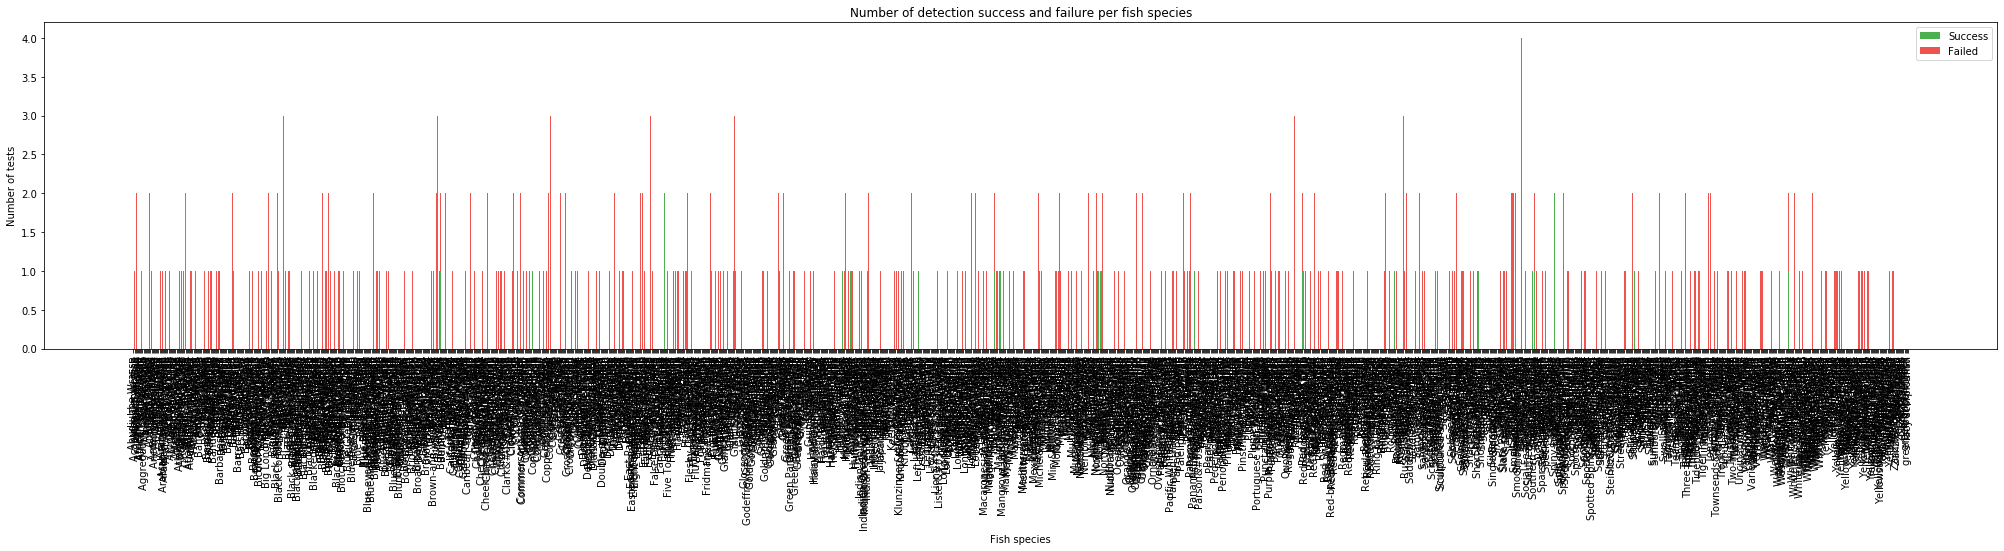

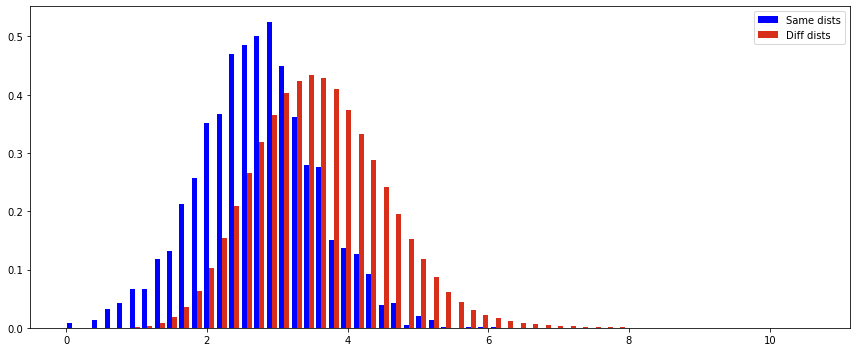

6296 500 3148000
2688 3144812
CPU times: user 1min 36s, sys: 2.28 s, total: 1min 39s
Wall time: 1min 38s


In [0]:
%%time
print("===== TRAINING STATS =====")
predict.build()
print("Build 1")
same_dists, diff_dists = eval_dists_on_sample(predict, train_datas_sample)
print("Build 2")
accuracy, good_results = evaluate_accuracy_train_datas()

print("Accuracy : {}%".format(accuracy*100))
print("Avg dist same class :", sum(same_dists) / len(same_dists))
print("Avg dist distinct classes :", sum(diff_dists) / len(diff_dists))

plot_results_per_class(good_results, train_labels, train_cls_names, sample=train_datas_sample)
plot_hist([same_dists, diff_dists])
print(len(train_images), ACCURACY_SAMPLE_SIZE, ACCURACY_SAMPLE_SIZE * len(train_images))
print(len(same_dists), len(diff_dists))

===== TESTING WITHIN SAME DATAS STATS =====
Accuracy : 8.4%
Avg dist same class : 2.9525186023277703
Avg dist distinct classes : 3.3252534709717114


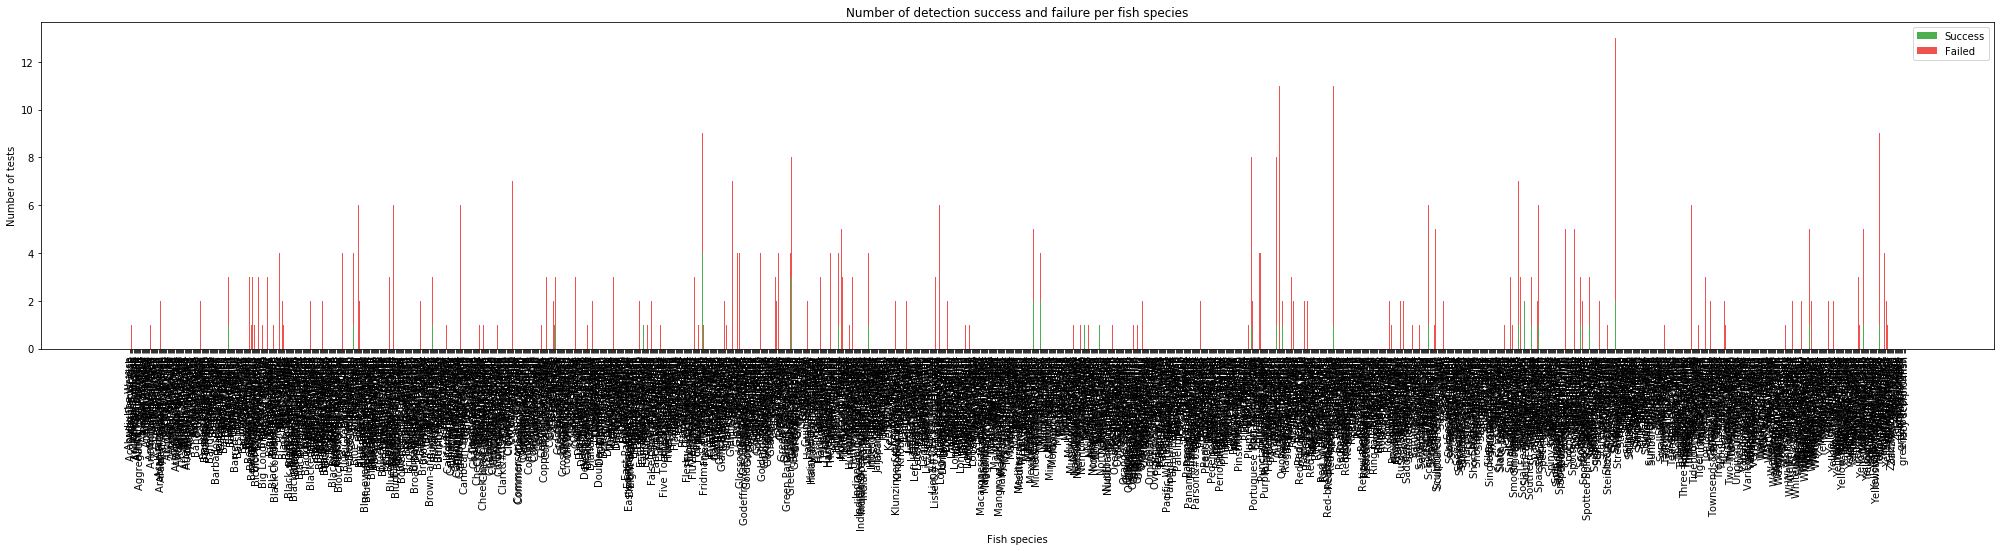

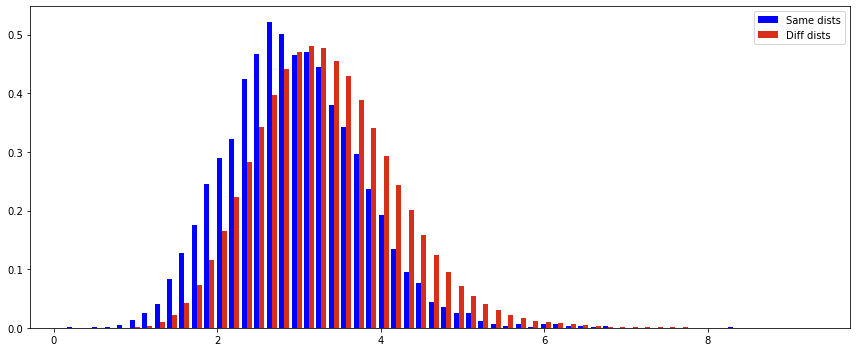

CPU times: user 53.3 s, sys: 2.24 s, total: 55.5 s
Wall time: 54.7 s


In [0]:
%%time
print("===== TESTING WITHIN SAME DATAS STATS =====")
predict_testing.build()
same_dists, diff_dists = eval_dists_on_sample(predict_testing, test_datas_sample)
accuracy, good_results = evaluate_accuracy_test_datas()

print("Accuracy : {}%".format(accuracy*100))
print("Avg dist same class :", sum(same_dists) / len(same_dists))
print("Avg dist distinct classes :", sum(diff_dists) / len(diff_dists))

plot_results_per_class(good_results, test_labels, test_cls_names, sample=test_datas_sample)
plot_hist([same_dists, diff_dists])

In [0]:
# %%time
# print("===== TESTING WITH DIFFERENT DATAS STATS =====")
# predict_base.build()
# # same_dists, diff_dists = eval_dists_on_sample(predict_base, test_datas_sample)

# accuracy, good_results = evaluate_accuracy(predict_base, test_images, test_labels)
# print("Accuracy : {}%".format(accuracy*100))
# plot_results_per_class(good_results, test_labels, test_cls_names)

# # print("Avg dist same class :", sum(same_dists) / len(same_dists))
# # print("Avg dist distinct classes :", sum(diff_dists) / len(diff_dists))
# # plot_hist([same_dists, diff_dists])

In [0]:
# %matplotlib inline

# for _ in range(3):
#     try:
#         pl.clf()
#         pl.plot(pd.Series(data=np.random.randn(100), index=i))
#         display.display(pl.gcf())
#         display.clear_output(wait=True)
#         time.sleep(1)
#     except KeyboardInterrupt:
#         break